In [6]:
# General imports
import os
import sys
import pandas as pd

pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import subprocess

# Other imports
import multiprocessing
import parmap
import collections
from tqdm import tqdm

tqdm.pandas()

import json
from pandarallel import pandarallel

pandarallel.initialize(nb_workers=60, progress_bar=True)
from pprint import pprint

# Custom utils
sys.path.append("/home/weber/PycharmProjects/EXOTIC/src")
from utils.utils import load_config_file

# Figures imports
import matplotlib

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from statannot import add_stat_annotation
import matplotlib.font_manager as font_manager

# Font settings
font_dirs = ['/home/weber/Fonts', ]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
font_list = font_manager.createFontList(font_files)
font_manager.fontManager.ttflist.extend(font_list)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.weight'] = 'light'

## YAML FILES CONFIG
yaml = load_config_file(config_file="/home/weber/PycharmProjects/EXOTIC/clean/src/config_clean_clean.yaml")

dicts = json.load(open("/home/weber/PycharmProjects/EXOTIC/src/EXOTIC_config.json"))


INFO: Pandarallel will run on 60 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


In [3]:
exotic

,symbol,ensg,HGNC,Exon,mRNA_nb,mRNA_nb_total,MAP,mean_proportion,Adipose - Subcutaneous,Adipose - Visceral (Omentum),...,new_mRNA_gene,new_mRNA_nb_total,Ratio,CDS_start,CDS_stop,Share,Length,Ratio_num,Const_Alt,CDS_count
0,A2ML1,ENSG00000166535,23336,8975248-8975309,1,2,A2ML1_8975248-8975309,0.69514,0.156704,0.156704,...,"[NM_144670, NM_001282424]",2,1/2,8975248,8975309,False,61,0.500000,Alt,36
1,A2ML1,ENSG00000166535,23336,8975778-8975961,1,2,A2ML1_8975778-8975961,0.69514,0.156704,0.156704,...,"[NM_144670, NM_001282424]",2,1/2,8975778,8975961,False,183,0.500000,Alt,36
2,A2ML1,ENSG00000166535,23336,8976316-8976478,1,2,A2ML1_8976316-8976478,0.69514,0.156704,0.156704,...,"[NM_144670, NM_001282424]",2,1/2,8976316,8976478,False,162,0.500000,Alt,36
3,A2ML1,ENSG00000166535,23336,8982323-8982375,1,2,A2ML1_8982323-8982375,0.69514,0.156704,0.156704,...,"[NM_144670, NM_001282424]",2,1/2,8982323,8982375,False,52,0.500000,Alt,36
4,A2ML1,ENSG00000166535,23336,8987258-8987278,1,2,A2ML1_8987258-8987278,0.69514,0.156704,0.156704,...,"[NM_144670, NM_001282424]",2,1/2,8987258,8987278,False,20,0.500000,Alt,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29295,ZXDC,ENSG00000070476,28160,126158475-126158570,1,2,ZXDC_126158475-126158570,0.20989,0.000470,0.009736,...,"[NM_025112, NM_001040653]",2,1/2,126158475,126158570,False,95,0.500000,Alt,11
29296,ZXDC,ENSG00000070476,28160,126160608-126160789,1,2,ZXDC_126160608-126160789,0.20989,0.000470,0.009736,...,"[NM_025112, NM_001040653]",2,1/2,126160608,126160789,False,181,0.500000,Alt,11
29297,ZXDC,ENSG00000070476,28160,126178496-126178580,1,2,ZXDC_126178496-126178580,0.20989,0.000470,0.009736,...,"[NM_025112, NM_001040653]",2,1/2,126178496,126178580,False,84,0.500000,Alt,11
29298,ZXDC,ENSG00000070476,28160,126180378-126181063,1,2,ZXDC_126180378-126181063,0.34803,0.030669,0.014999,...,"[NM_025112, NM_001040653]",2,1/2,126180378,126181063,False,685,0.500000,Alt,11


In [10]:
biomart = pd.read_csv(yaml['1_GENOMICS']['External']['biomart_37'], compression='gzip', sep='\t')
biomart = biomart.loc[~biomart['Chromosome/scaffold name'].str.contains('HG|CHR|GL')].rename({'Chromosome/scaffold name' : 'CHROM', 'Gene name' : 'symbol'}, axis=1)
# biomart['Chromosome/scaffold name'].value_counts()
exotic = pd.read_parquet("/gstock/EXOTIC/data/EXOTIC/EXOTIC_modified_zscore_mean_prop_corrected_with_variable.parquet")
exotic = pd.merge(biomart[['CHROM', 'symbol']], exotic, on='symbol')
exotic[['CHROM', 'CDS_start', 'CDS_stop', 'MAP']].sort_values(by=['CHROM', 'CDS_start']).to_csv('/biolo/ngs/remap/EXOTIC.bed', header=False,sep='\t', index=False)
exotic[['CHROM', 'CDS_start', 'CDS_stop', 'MAP']].sort_values(by=['CHROM', 'CDS_start'])


,CHROM,CDS_start,CDS_stop,MAP
302633,1,10002739,10002793,LZIC_10002739-10002793
302640,1,10002739,10002793,LZIC_10002739-10002793
302647,1,10002739,10002793,LZIC_10002739-10002793
302654,1,10002739,10002793,LZIC_10002739-10002793
302661,1,10002739,10002793,LZIC_10002739-10002793
...,...,...,...,...
149515,Y,2844711,2844863,ZFY_2844711-2844863
149519,Y,2844711,2844863,ZFY_2844711-2844863
149523,Y,2844711,2844863,ZFY_2844711-2844863
149527,Y,2844711,2844863,ZFY_2844711-2844863


In [15]:
import subprocess
subprocess.call("/usr/local/bin/perl /biolo/ngs/remap/remap_api.pl --mode asm-asm --from GCF_000001405.25 --dest GCF_000001405.26 --annotation /biolo/ngs/remap/EXOTIC.bed --annot_out /biolo/ngs/remap/EXOTIC_remap.bed --report_out report --in_format bed --out_format bed")
# from subprocess import Popen, PIPE

# process = Popen(["/usr/local/bin/perl", "remap_api.pl", "--mode", "asm-asm", "--from", "GCF_000001405.25", "--dest", "GCF_000001405.26", "--annotation", "/biolo/ngs/remap/EXOTIC.bed", "--annot_out", "/biolo/ngs/remap/EXOTIC_remap.bed", "--report_out", "report", "--in_format", "bed", "--out_format", "bed"], stdout=PIPE, stderr=PIPE)
# stdout, stderr = process.communicate()
# exotic_remap_map = pd.read_csv('/biolo/ngs/remap/EXOTIC_remap.bed', sep='\t', names=['CHROM_38', 'Exon_start_38', 'Exon_end_38', 'MAP'])
# exotic_remap_map = exotic_remap_map.loc[~exotic_remap_map['CHROM_38'].str.contains('HSCHR')]
# exotic_remap_map

FileNotFoundError: [Errno 2] No such file or directory: '/usr/local/bin/perl /biolo/ngs/remap/remap_api.pl --mode asm-asm --from GCF_000001405.25 --dest GCF_000001405.26 --annotation /biolo/ngs/remap/EXOTIC.bed --annot_out /biolo/ngs/remap/EXOTIC_remap.bed --report_out report --in_format bed --out_format bed': '/usr/local/bin/perl /biolo/ngs/remap/remap_api.pl --mode asm-asm --from GCF_000001405.25 --dest GCF_000001405.26 --annotation /biolo/ngs/remap/EXOTIC.bed --annot_out /biolo/ngs/remap/EXOTIC_remap.bed --report_out report --in_format bed --out_format bed'

In [14]:
mainpath = "/home/weber/PycharmProjects/ExoCarto/"
refseq_bc = pd.read_csv(mainpath + files['RefSeq']['df_transposed_gene_file'], compression='gzip', sep='\t')
refseq_ac = pd.read_parquet(files['RefSeq']['refseq_corrected_lite'])


,Gene,ranges,new_mRNA_exons,new_mRNA_nb,new_mRNA_gene,new_mRNA_nb_total,new_Ratio,new_Ratio_num,Const_Alt,new_Ratio_num_bins,Start,End,Length,new_CDS_count
0,A2M,9220419-9220435,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,4/4,1.0,Const,0.8 - 1,9220419,9220435,16,38
1,A2M,9220779-9220820,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,4/4,1.0,Const,0.8 - 1,9220779,9220820,41,38
2,A2M,9221336-9221438,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,4/4,1.0,Const,0.8 - 1,9221336,9221438,102,38
3,A2M,9222341-9222409,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,4/4,1.0,Const,0.8 - 1,9222341,9222409,68,38
4,A2M,9223084-9223174,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,4/4,1.0,Const,0.8 - 1,9223084,9223174,90,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176794,ZZZ3,78047461-78047576,"[NM_001308237, NM_015534]",2,"[NM_001308237, NM_015534]",2,2/2,1.0,Const,0.8 - 1,78047461,78047576,115,12
176795,ZZZ3,78047664-78047811,"[NM_001308237, NM_015534]",2,"[NM_001308237, NM_015534]",2,2/2,1.0,Const,0.8 - 1,78047664,78047811,147,12
176796,ZZZ3,78050202-78050340,"[NM_001308237, NM_015534]",2,"[NM_001308237, NM_015534]",2,2/2,1.0,Const,0.8 - 1,78050202,78050340,138,12
176797,ZZZ3,78097535-78099039,[NM_015534],1,"[NM_001308237, NM_015534]",2,1/2,0.5,Alt,0.4 - 0.6,78097535,78099039,1504,12


In [15]:
refseq_bc

,ID,Source,Element,Start,End,Score,Brin,Phase,CCDS,Dbxref,...,Elem_position_ID,CDS_num,mRNA_num,mRNA_nb,Count,Count_CDS_alternative,Count_CDS_constitutive,mRNA_IDS,CDS_locations_corrected,HGNC
0,NC_000019.9,BestRefSeq,gene,58856549,58864858,.,-,.,NaN,"GeneID:1,HGNC:HGNC:5,MIM:138670",...,58856549_58864858,NaN,NaN,1,NaN,0,8,['NM_130786.4'],"{(58858388, 58858395): {'Sources': [(58858388,...",5.0
1,NC_000008.10,BestRefSeq,gene,18248792,18258728,.,+,.,NaN,"GeneID:10,HGNC:HGNC:7646,MIM:612182",...,18248792_18258728,NaN,NaN,1,NaN,0,1,['NM_000015.3'],"{(18257514, 18258386): {'Sources': [(18257514,...",7646.0
2,NC_000020.10,BestRefSeq,gene,43248160,43280399,.,-,.,NaN,"GeneID:100,HGNC:HGNC:186,MIM:608958",...,43248160_43280399,NaN,NaN,3,NaN,7,6,"['NM_001322050.1', 'NM_001322051.1', 'NM_00002...","{(43248475, 43248488): {'Sources': [(43248475,...",186.0
3,NC_000018.9,BestRefSeq,gene,25530930,25757094,.,-,.,NaN,"GeneID:1000,HGNC:HGNC:1759,MIM:114020",...,25530930_25757094,NaN,NaN,2,NaN,3,14,"['NM_001792.5', 'NM_001308176.2']","{(25532117, 25532323): {'Sources': [(25532117,...",1759.0
4,NC_000001.10,BestRefSeq,gene,243651535,244014381,.,-,.,NaN,"GeneID:10000,HGNC:HGNC:393,MIM:611223",...,243651535_244014381,NaN,NaN,4,NaN,2,12,"['NM_181690.2', 'NM_001206729.1', 'NM_00137007...","{(243663045, 243663088): {'Sources': [(2436630...",393.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19318,NC_000009.11,BestRefSeq,gene,114979995,115095944,.,-,.,NaN,"GeneID:9991,HGNC:HGNC:10253,MIM:607527",...,114979995_115095944,NaN,NaN,6,NaN,10,10,"['NM_001163790.2', 'NM_001244896.2', 'NM_00124...","{(114982452, 114982653): {'Sources': [(1149824...",10253.0
19319,NC_000021.8,BestRefSeq,gene,35736323,35743440,.,+,.,NaN,"GeneID:9992,HGNC:HGNC:6242,MIM:603796",...,35736323_35743440,NaN,NaN,1,NaN,0,1,['NM_172201.1'],"{(35742778, 35743149): {'Sources': [(35742778,...",6242.0
19320,NC_000022.10,BestRefSeq,gene,19023795,19109967,.,-,.,NaN,"GeneID:9993,HGNC:HGNC:2845,MIM:600594",...,19023795_19109967,NaN,NaN,4,NaN,3,8,"['NM_001173533.1', 'NM_001173534.2', 'NM_00118...","{(19026378, 19026634): {'Sources': [(19026378,...",2845.0
19321,NC_000006.11,BestRefSeq,gene,90539599,90584155,.,+,.,NaN,"GeneID:9994,HGNC:HGNC:1510,MIM:606880",...,90539599_90584155,NaN,NaN,3,NaN,0,9,"['NM_012115.4', 'NM_001137667.2', 'NM_00113766...","{(90556309, 90556363): {'Sources': [(90556309,...",1510.0


In [43]:
refseq_ac

,Gene,ranges,new_mRNA_exons,new_mRNA_nb,new_mRNA_gene,new_mRNA_nb_total,new_Ratio,new_Ratio_num,Const_Alt,new_Ratio_num_bins,Start,End,Length,new_CDS_count
0,A2M,9220419-9220435,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,4/4,1.0,Const,0.8 - 1,9220419,9220435,16,38
1,A2M,9220779-9220820,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,4/4,1.0,Const,0.8 - 1,9220779,9220820,41,38
2,A2M,9221336-9221438,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,4/4,1.0,Const,0.8 - 1,9221336,9221438,102,38
3,A2M,9222341-9222409,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,4/4,1.0,Const,0.8 - 1,9222341,9222409,68,38
4,A2M,9223084-9223174,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,"[NM_001347423, NM_001347425, NM_000014, NM_001...",4,4/4,1.0,Const,0.8 - 1,9223084,9223174,90,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176794,ZZZ3,78047461-78047576,"[NM_001308237, NM_015534]",2,"[NM_001308237, NM_015534]",2,2/2,1.0,Const,0.8 - 1,78047461,78047576,115,12
176795,ZZZ3,78047664-78047811,"[NM_001308237, NM_015534]",2,"[NM_001308237, NM_015534]",2,2/2,1.0,Const,0.8 - 1,78047664,78047811,147,12
176796,ZZZ3,78050202-78050340,"[NM_001308237, NM_015534]",2,"[NM_001308237, NM_015534]",2,2/2,1.0,Const,0.8 - 1,78050202,78050340,138,12
176797,ZZZ3,78097535-78099039,[NM_015534],1,"[NM_001308237, NM_015534]",2,1/2,0.5,Alt,0.4 - 0.6,78097535,78099039,1504,12


In [46]:
diff = list(set(refseq_bc.loc[refseq_bc['mRNA_nb'] == 1].Name.values.tolist()).difference(set(refseq_ac.Gene.values.tolist())))
print(diff)
# # diff = [sub_e for e in diff for sub_e in e.split('-')]
# diff = ["".join(filter(lambda x: x.isalpha(), e))  for e in diff]
# import collections
# df = pd.DataFrame.from_dict(dict(collections.Counter(diff)), orient='index')

['BPIFC', 'MUC5AC', 'VHLL', 'CRYBA4', 'OR4D9', 'H2AC4', 'PPIAL4F', 'FOXD4L4', 'OR51V1', 'DCANP1', 'FLJ44635', 'PRAMEF11', 'RDH12', 'XAGE5', 'OR10J4', 'DPPA5', 'GUCY2D', 'CT47A7', 'MUC2', 'FAM47C', 'OR5AS1', 'FOXD4L6', 'TRIM49C', 'SSMEM1', 'NXF2B', 'HNRNPCL2', 'DEFB103B', 'PGK2', 'H2AB3', 'POU4F1', 'AVP', 'CTAG1A', 'FAM186A', 'LOC100132202', 'SLC22A25', 'KRT37', 'KRTAP26-1', 'LOC112577592', 'MTRNR2L7', 'OR5AC2', 'SLC22A16', 'GPR52', 'KRT32', 'KRT9', 'CFC1B', 'FAM90A26', 'TMPRSS9', 'OR52N2', 'OR5P2', 'TCL1B', 'SLC22A9', 'P3R3URF', 'LMAN1L', 'GJE1', 'ZNF793', 'ELOA', 'TRIM64B', 'PRR36', 'MDS2', 'MANBA', 'BTNL10', 'ZC3H12D', 'KRTAP5-5', 'FNDC7', 'DEFA5', 'TEDDM1', 'SLC26A4', 'MSGN1', 'NRG4', 'COL22A1', 'ABHD1', 'LOC390877', 'ANKRD63', 'TCP10L2', 'OR52H1', 'USP27X', 'H4C2', 'BTNL2', 'EDDM3B', 'DEFB136', 'KRTAP2-3', 'HYAL4', 'OR5R1', 'PLIN4', 'ALPP', 'PRR25', 'WNT8B', 'CDR1', 'KIR2DL1', 'OR6C68', 'SLC25A53', 'LCN15', 'SOGA3', 'SMIM38', 'LCN12', 'EIF3I', 'COL19A1', 'UGT2B15', 'POU4F2', 'KRTAP

In [38]:
pd.options.display.max_rows = 100
df.sort_values(by=0, ascending=False).head(100)



,0
Corf,119
KRTAP,89
SLCA,75
LOC,48
ORA,44
ORC,34
CCDC,32
TMEM,32
ORB,28
ZNF,28


In [47]:
t = pd.read_parquet("/gstock/EXOTIC/data/VARIATIONS/CCRS_modified_refseq_corrected_Rdata.parquet")
t

,Gene,RefSeq_Chrom,CCRS_ranges,CCRS_Start,CCRS_End,CCRS_CCR_percentile,Missing_coverage_bp,Gap_with_previous_CCRS,ranges,Ratio_num,...,CCR_95_99_bool,CCR_99_100_bool,CCR_95_100_bool,Constitutive,Alternative,Cat80100,Cat6080,Cat4060,Cat2040,Cat0020
0,A2M,12,9220421-9220435,9220421,9220435,94.960308,0.0,None,9220419-9220435,1.0,...,False,False,False,True,False,False,False,False,False,False
1,A2M,12,9220792-9220793,9220792,9220793,0.000000,0.0,None,9220779-9220820,1.0,...,False,False,False,True,False,False,False,False,False,False
2,A2M,12,9220793-9220810,9220793,9220810,72.870475,0.0,None,9220779-9220820,1.0,...,False,False,False,True,False,False,False,False,False,False
3,A2M,12,9220810-9220811,9220810,9220811,0.000000,0.0,None,9220779-9220820,1.0,...,False,False,False,True,False,False,False,False,False,False
4,A2M,12,9220811-9220820,9220811,9220820,96.319079,0.0,None,9220779-9220820,1.0,...,True,False,True,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1605118,ZXDC,3,126194500-126194505,126194500,126194505,0.204138,0.0,None,126193802-126194708,1.0,...,False,False,False,True,False,False,False,False,False,False
1605119,ZXDC,3,126194505-126194506,126194505,126194506,0.000000,0.0,None,126193802-126194708,1.0,...,False,False,False,True,False,False,False,False,False,False
1605120,ZXDC,3,126194506-126194508,126194506,126194508,2.763944,0.0,None,126193802-126194708,1.0,...,False,False,False,True,False,False,False,False,False,False
1605121,ZXDC,3,126194508-126194509,126194508,126194509,0.000000,0.0,None,126193802-126194708,1.0,...,False,False,False,True,False,False,False,False,False,False


In [50]:
t.drop_duplicates(subset=['Gene', 'ranges', 'CCRS_ranges'])

,Gene,RefSeq_Chrom,CCRS_ranges,CCRS_Start,CCRS_End,CCRS_CCR_percentile,Missing_coverage_bp,Gap_with_previous_CCRS,ranges,Ratio_num,...,CCR_95_99_bool,CCR_99_100_bool,CCR_95_100_bool,Constitutive,Alternative,Cat80100,Cat6080,Cat4060,Cat2040,Cat0020
0,A2M,12,9220421-9220435,9220421,9220435,94.960308,0.0,None,9220419-9220435,1.0,...,False,False,False,True,False,False,False,False,False,False
1,A2M,12,9220792-9220793,9220792,9220793,0.000000,0.0,None,9220779-9220820,1.0,...,False,False,False,True,False,False,False,False,False,False
2,A2M,12,9220793-9220810,9220793,9220810,72.870475,0.0,None,9220779-9220820,1.0,...,False,False,False,True,False,False,False,False,False,False
3,A2M,12,9220810-9220811,9220810,9220811,0.000000,0.0,None,9220779-9220820,1.0,...,False,False,False,True,False,False,False,False,False,False
4,A2M,12,9220811-9220820,9220811,9220820,96.319079,0.0,None,9220779-9220820,1.0,...,True,False,True,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1605118,ZXDC,3,126194500-126194505,126194500,126194505,0.204138,0.0,None,126193802-126194708,1.0,...,False,False,False,True,False,False,False,False,False,False
1605119,ZXDC,3,126194505-126194506,126194505,126194506,0.000000,0.0,None,126193802-126194708,1.0,...,False,False,False,True,False,False,False,False,False,False
1605120,ZXDC,3,126194506-126194508,126194506,126194508,2.763944,0.0,None,126193802-126194708,1.0,...,False,False,False,True,False,False,False,False,False,False
1605121,ZXDC,3,126194508-126194509,126194508,126194509,0.000000,0.0,None,126193802-126194708,1.0,...,False,False,False,True,False,False,False,False,False,False


In [39]:
import sys
sys.path.append("/home/weber/PycharmProjects/EXOTIC/clean/src")
from utils import utils
yaml = utils.load_config_file(config_file="/home/weber/PycharmProjects/EXOTIC/clean/src/config_clean_clean.yaml")

In [34]:
import pandas as pd
df = pd.read_parquet(yaml["1_GENOMICS"]["Final"]["refseq_cds_with_variable"])

In [35]:
df.loc[df['mRNA_gene_nb'] > 1, ['Gene', 'mRNA_gene_nb']].drop_duplicates()

,Gene,mRNA_gene_nb
8,A1CF,8
21,A2M,4
59,A2ML1,2
100,A4GALT,2
103,AAAS,2
...,...,...
213119,ZWINT,3
213131,ZXDC,2
213142,ZYG11A,2
213171,ZYX,3


In [26]:
df

,Gene,Exon_type,ranges,mRNA_exons,Exon_start,Exon_stop,Length,Strand,mRNA_exons_nb,mRNA_gene,mRNA_gene_nb,Ratio,Ratio_num,Const_Alt
0,A1BG,Exon,58856549-58858395,[NM_130786],58856549,58858395,1846,0,1,[NM_130786],1,1/1,1.0,Const
1,A1BG,CDS,58858388-58858395,[NM_130786],58858388,58858395,7,0,1,[NM_130786],1,1/1,1.0,Const
2,A1BG,CDS,58858719-58859006,[NM_130786],58858719,58859006,287,0,1,[NM_130786],1,1/1,1.0,Const
3,A1BG,Exon,58858719-58859006,[NM_130786],58858719,58859006,287,0,1,[NM_130786],1,1/1,1.0,Const
4,A1BG,CDS,58861736-58862017,[NM_130786],58861736,58862017,281,0,1,[NM_130786],1,1/1,1.0,Const
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446750,ZZZ3,Exon,78105134-78105287,"[NM_001308237, NM_015534]",78105134,78105287,153,0,2,"[NM_015534, NM_001308237]",2,2/2,1.0,Const
446751,ZZZ3,Exon,78107069-78107131,"[NM_001308237, NM_015534]",78107069,78107131,62,0,2,"[NM_015534, NM_001308237]",2,2/2,1.0,Const
446752,ZZZ3,Exon,78107207-78107340,"[NM_001308237, NM_015534]",78107207,78107340,133,0,2,"[NM_015534, NM_001308237]",2,2/2,1.0,Const
446753,ZZZ3,Exon,78148270-78148343,[NM_015534],78148270,78148343,73,0,1,"[NM_015534, NM_001308237]",2,1/2,0.5,Alt


In [21]:
df.Gene.nunique()

19306

In [36]:
df.loc[df['Exon_type'] == 'CDS'].drop_duplicates(subset=['Gene', 'ranges'])['Const_Alt'].value_counts()

Const    158667
Alt       54515
Name: Const_Alt, dtype: int64

In [37]:
df.loc[(df['mRNA_gene_nb'] > 1 ) & (df['Exon_type'] == 'CDS')].drop_duplicates(subset=['Gene', 'ranges'])['Const_Alt'].value_counts()

Const    90073
Alt      54515
Name: Const_Alt, dtype: int64

In [40]:
utrs = pd.read_parquet(yaml["1_GENOMICS"]["Final"]["refseq_miso_utrs"])

In [42]:
df.loc[(~df['Gene'].isin(utrs.loc[utrs['Nb_combi'] == 1].Gene.values.tolist()) ) & (df['mRNA_gene_nb'] > 1 ) & (df['Exon_type'] == 'CDS')].drop_duplicates(subset=['Gene', 'ranges'])['Const_Alt'].value_counts()

Const    82152
Alt      54515
Name: Const_Alt, dtype: int64

In [16]:
df2 = pd.read_csv('/home/weber/PycharmProjects/ExoCarto/data/2_processed/DF_transformed.csv.gz', compression='gzip', sep='\t')
df2['Ratio_num'] = df2['Ratio'].apply(eval)
df2.loc[df2['Ratio_num'] < 1, 'Const_Alt'] = 'Alt'
df2.loc[df2['Ratio_num'] == 1, 'Const_Alt'] = 'Const'


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
df2

,Gene,Chrom,Start,End,ranges,Length,GeneID,HGNC,CDS_representation,Ratio,Sharing_status,Sources,Count_CDS_alternative,Count_CDS_constitutive,mRNA_IDS,mRNA_nb,Ratio_num,Const_Alt
0,OR4F5,1,69091,70008,69091-70008,917,79501,14825.0,Unique,1.0/1,False,"[(69091, 70008, '1.0/1')]",0,1,['NM_001005484.1'],1,1.0,Const
1,OR4F29,1,367659,368597,367659-368597,938,729759,31275.0,Unique,1.0/1,False,"[(367659, 368597, '1.0/1')]",0,1,['NM_001005221.2'],1,1.0,Const
2,OR4F16,1,621096,622034,621096-622034,938,81399,15079.0,Unique,1.0/1,False,"[(621096, 622034, '1.0/1')]",0,1,['NM_001005277.1'],1,1.0,Const
3,SAMD11,1,861322,861393,861322-861393,71,148398,28706.0,Unique,1.0/1,False,"[(861322, 861393, '1.0/1')]",0,13,['NM_152486.3'],1,1.0,Const
4,SAMD11,1,865535,865716,865535-865716,181,148398,28706.0,Unique,1.0/1,False,"[(865535, 865716, '1.0/1')]",0,13,['NM_152486.3'],1,1.0,Const
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238564,CDY1,Y,27768590,27770181,27768590-27770181,1591,9085,1809.0,Variable_region,2.0/2,True,"[(27768590, 27770181, '1.0/2'), (27768590, 277...",2,1,"['NM_004680.2', 'NM_170723.1']",2,1.0,Const
238565,CDY1,Y,27770181,27770212,27770181-27770212,31,9085,1809.0,Variable_region,1.0/2,True,"[(27768590, 27770212, '1.0/2')]",2,1,"['NM_004680.2', 'NM_170723.1']",2,0.5,Alt
238566,CDY1,Y,27770181,27770212,27770181-27770212,31,9085,1809.0,Variable_region,1.0/2,True,"[(27768590, 27770212, '1.0/2')]",2,1,"['NM_004680.2', 'NM_170723.1']",2,0.5,Alt
238567,CDY1,Y,27770602,27770674,27770602-27770674,72,9085,1809.0,Unique,1.0/2,False,"[(27770602, 27770674, '1.0/2')]",2,1,"['NM_004680.2', 'NM_170723.1']",2,0.5,Alt


In [19]:
df2.Gene.nunique()

19260

In [22]:
df2.drop_duplicates(subset=['Gene', 'ranges'])['Const_Alt'].value_counts()

Const    161705
Alt       50897
Name: Const_Alt, dtype: int64

In [24]:
df2.loc[df2['mRNA_nb'] > 1 ].drop_duplicates(subset=['Gene', 'ranges'])['Const_Alt'].value_counts()

Const    93326
Alt      50897
Name: Const_Alt, dtype: int64

In [7]:
yaml = load_config_file(config_file="../clean/src/config_clean_clean.yaml")

refseq = pd.read_parquet(yaml["2_EXPRESSION"]["Final"]["refseq_corrected_cds_recomputed"])
biomart = pd.read_csv(yaml["1_GENOMICS"]["External"]["biomart"], compression="gzip", sep="\t")

# biomart = (
#     biomart[["Gene stable ID", "HGNC ID", "Gene name", "Chromosome/scaffold name"]]
#     .rename(
#         {"Gene stable ID": "ENSG", "HGNC ID": "HGNC", "Gene name": "Gene", "Chromosome/scaffold name" : "CHROM"},
#         axis=1,
#     )
#     .drop_duplicates()
# )



biomart.loc[biomart['APPRIS annotation'] == 'principal1', '']
# biomart['APPRIS annotation'].value_counts()

,Gene stable ID,Gene end (bp),Gene start (bp),Gene name,Transcript start (bp),Transcript end (bp),Transcription start site (TSS),Transcript stable ID,Transcript support level (TSL),APPRIS annotation,Transcript type,Gene type,HGNC ID,RefSeq mRNA ID,Chromosome/scaffold name
0,ENSG00000198888,4262,3307,MT-ND1,3307,4262,3307,ENST00000361390,tslNA,principal1,protein_coding,protein_coding,HGNC:7455,NaN,MT
1,ENSG00000198763,5511,4470,MT-ND2,4470,5511,4470,ENST00000361453,tslNA,principal1,protein_coding,protein_coding,HGNC:7456,NaN,MT
2,ENSG00000198804,7445,5904,MT-CO1,5904,7445,5904,ENST00000361624,tslNA,principal1,protein_coding,protein_coding,HGNC:7419,NaN,MT
3,ENSG00000198712,8269,7586,MT-CO2,7586,8269,7586,ENST00000361739,tslNA,principal1,protein_coding,protein_coding,HGNC:7421,NaN,MT
4,ENSG00000228253,8572,8366,MT-ATP8,8366,8572,8366,ENST00000361851,tslNA,principal1,protein_coding,protein_coding,HGNC:7415,NaN,MT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194898,ENSG00000175137,248825915,248810446,SH3BP5L,248810446,248825915,248825915,ENST00000366472,tsl1 (assigned to previous version 5),principal1,protein_coding,protein_coding,HGNC:29360,NM_030645,1
194899,ENSG00000175137,248825915,248810446,SH3BP5L,248810446,248825915,248825915,ENST00000366472,tsl1 (assigned to previous version 5),principal1,protein_coding,protein_coding,HGNC:29360,NM_001322464,1
194900,ENSG00000175137,248825915,248810446,SH3BP5L,248810446,248825915,248825915,ENST00000366472,tsl1 (assigned to previous version 5),principal1,protein_coding,protein_coding,HGNC:29360,NM_001322463,1
194904,ENSG00000171161,248849517,248838210,ZNF672,248838224,248849517,248838224,ENST00000306562,tsl1 (assigned to previous version 7),principal1,protein_coding,protein_coding,HGNC:26179,NM_024836,1


In [8]:
pd.read_csv(yaml["1_GENOMICS"]["External"]["biomart"], compression="gzip", sep="\t")

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Gene stable ID,Gene end (bp),Gene start (bp),Gene name,Transcript start (bp),Transcript end (bp),Transcription start site (TSS),Transcript stable ID,Transcript support level (TSL),APPRIS annotation,Transcript type,Gene type,HGNC ID,RefSeq mRNA ID,Chromosome/scaffold name
0,ENSG00000198888,4262,3307,MT-ND1,3307,4262,3307,ENST00000361390,tslNA,principal1,protein_coding,protein_coding,HGNC:7455,NaN,MT
1,ENSG00000198763,5511,4470,MT-ND2,4470,5511,4470,ENST00000361453,tslNA,principal1,protein_coding,protein_coding,HGNC:7456,NaN,MT
2,ENSG00000198804,7445,5904,MT-CO1,5904,7445,5904,ENST00000361624,tslNA,principal1,protein_coding,protein_coding,HGNC:7419,NaN,MT
3,ENSG00000198712,8269,7586,MT-CO2,7586,8269,7586,ENST00000361739,tslNA,principal1,protein_coding,protein_coding,HGNC:7421,NaN,MT
4,ENSG00000228253,8572,8366,MT-ATP8,8366,8572,8366,ENST00000361851,tslNA,principal1,protein_coding,protein_coding,HGNC:7415,NaN,MT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194939,ENSG00000171163,248859144,248850006,ZNF692,248857865,248859144,248859144,ENST00000534456,tsl4,NaN,retained_intron,protein_coding,HGNC:26049,NaN,1
194940,ENSG00000171163,248859144,248850006,ZNF692,248857975,248859033,248859033,ENST00000533976,tsl4,NaN,retained_intron,protein_coding,HGNC:26049,NaN,1
194941,ENSG00000185220,248919946,248906196,PGBD2,248906196,248919946,248906196,ENST00000355360,tsl1,NaN,protein_coding,protein_coding,HGNC:19399,NM_001017434,1
194942,ENSG00000185220,248919946,248906196,PGBD2,248906235,248919146,248906235,ENST00000329291,tsl1 (assigned to previous version 5),principal1,protein_coding,protein_coding,HGNC:19399,NM_170725,1


In [17]:
refseq2 = pd.merge(refseq, biomart, on="Gene")
refseq2['CHROM'] = refseq2['CHROM'].astype(str)
refseq2 = refseq2.loc[~refseq2['CHROM'].str.contains('HSCHR|HG')]
refseq2

,Gene,ranges,mRNA_exons,mRNA_nb,Share,Strand,mRNA_gene,mRNA_nb_total,Ratio,Ratio_num,...,Ratio_num_bins,Ratio_num_bins_update,MAP,Start,End,Length,CDS_count,ENSG,HGNC,CHROM
0,A2M,9220419-9220435,"[NM_001347425, NM_001347423, NM_000014, NM_001...",4,False,0,"[NM_001347425, NM_001347423, NM_000014, NM_001...",4,4/4,1.0,...,0.8 - 1,1.00,A2M_9220419-9220435,9220419,9220435,16,38,ENSG00000175899,HGNC:7,12
1,A2M,9220779-9220820,"[NM_001347425, NM_001347423, NM_000014, NM_001...",4,False,0,"[NM_001347425, NM_001347423, NM_000014, NM_001...",4,4/4,1.0,...,0.8 - 1,1.00,A2M_9220779-9220820,9220779,9220820,41,38,ENSG00000175899,HGNC:7,12
2,A2M,9221336-9221438,"[NM_001347425, NM_001347423, NM_000014, NM_001...",4,False,0,"[NM_001347425, NM_001347423, NM_000014, NM_001...",4,4/4,1.0,...,0.8 - 1,1.00,A2M_9221336-9221438,9221336,9221438,102,38,ENSG00000175899,HGNC:7,12
3,A2M,9222341-9222409,"[NM_001347425, NM_001347423, NM_000014, NM_001...",4,False,0,"[NM_001347425, NM_001347423, NM_000014, NM_001...",4,4/4,1.0,...,0.8 - 1,1.00,A2M_9222341-9222409,9222341,9222409,68,38,ENSG00000175899,HGNC:7,12
4,A2M,9223084-9223174,"[NM_001347425, NM_001347423, NM_000014, NM_001...",4,False,0,"[NM_001347425, NM_001347423, NM_000014, NM_001...",4,4/4,1.0,...,0.8 - 1,1.00,A2M_9223084-9223174,9223084,9223174,90,38,ENSG00000175899,HGNC:7,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194650,ZZZ3,78047461-78047576,"[NM_001308237, NM_015534]",2,False,0,"[NM_001308237, NM_015534]",2,2/2,1.0,...,0.8 - 1,1.00,ZZZ3_78047461-78047576,78047461,78047576,115,12,ENSG00000036549,HGNC:24523,1
194651,ZZZ3,78047664-78047811,"[NM_001308237, NM_015534]",2,False,0,"[NM_001308237, NM_015534]",2,2/2,1.0,...,0.8 - 1,1.00,ZZZ3_78047664-78047811,78047664,78047811,147,12,ENSG00000036549,HGNC:24523,1
194652,ZZZ3,78050202-78050340,"[NM_001308237, NM_015534]",2,False,0,"[NM_001308237, NM_015534]",2,2/2,1.0,...,0.8 - 1,1.00,ZZZ3_78050202-78050340,78050202,78050340,138,12,ENSG00000036549,HGNC:24523,1
194653,ZZZ3,78097535-78099039,[NM_015534],1,False,0,"[NM_001308237, NM_015534]",2,1/2,0.5,...,0.4 - 0.6,0.4 - 0.6,ZZZ3_78097535-78099039,78097535,78099039,1504,12,ENSG00000036549,HGNC:24523,1


In [18]:
refseq2.CHROM.unique()

array(['12', '22', '3', '4', '15', '2', '11', '17', '20', '8', '16', '6',
       '7', '9', '1', '19', 'X', '13', '14', '21', '18', '10', '5', 'Y'],
      dtype=object)

In [50]:
dext = pd.read_parquet("/gstock/EXOTIC/data/EXOTIC/dext_modified_zscore_mean_prop_corrected_with_variable.parquet")
dext.loc[dext['Gene'] == 'A2ML1'][['ranges', 'Vagina']]


,ranges,Vagina
0,8975248-8975309,-0.000084
1,8975778-8975961,-0.000084
2,8976316-8976478,-0.000084
3,8982323-8982375,-0.000084
4,8987258-8987278,-0.000084
5,8988103-8988262,-0.000084
6,8988851-8988935,-0.000084
7,8990036-8990162,-0.000084
8,8990932-8991046,-0.000084
9,8991709-8991818,-0.000084


In [48]:
exotic = pd.read_parquet("/gstock/EXOTIC/data/EXOTIC/EXOTIC_modified_zscore_mean_prop_corrected_with_variable.parquet")
exotic.loc[exotic['Gene'] == 'A2ML1'][['Exon', 'Vagina']]


,Exon,Vagina
0,8975248-8975309,-0.000084
1,8975778-8975961,-0.000084
2,8976316-8976478,-0.000084
3,8982323-8982375,-0.000084
4,8987258-8987278,-0.000084
5,8988103-8988262,-0.000084
6,8988851-8988935,-0.000084
7,8990036-8990162,-0.000084
8,8990932-8991046,-0.000084
9,8991709-8991818,-0.000084


In [44]:
pext_before = pd.read_parquet('/gstock/EXOTIC/data/EXPRESSION/RefSeq_PEXT_2021.parquet')
# pext_before.loc[pext_after['MAP'].str.contains('A2ML1')].to_dict()
pext_before.loc[pext_before['Exon'] == '8975248-8975309'].to_dict()


{'HGNC ID': {144430: 23336.0},
 'symbol': {144430: 'A2ML1'},
 'ensg': {144430: 'ENSG00000166535'},
 'Exon': {144430: '8975248-8975309'},
 'Adipose_Subcutaneous': {144430: 1.0},
 'Adipose_Visceral_Omentum_': {144430: 1.0},
 'AdrenalGland': {144430: 1.0},
 'Artery_Aorta': {144430: 1.0},
 'Artery_Coronary': {144430: 1.0},
 'Artery_Tibial': {144430: 1.0},
 'Bladder': {144430: 0.67816},
 'Brain_Amygdala': {144430: 0.36482},
 'Brain_Anteriorcingulatecortex_BA24_': {144430: 0.34302},
 'Brain_Caudate_basalganglia_': {144430: 0.3439},
 'Brain_CerebellarHemisphere': {144430: 0.17518},
 'Brain_Cerebellum': {144430: 0.22973000000000002},
 'Brain_Cortex': {144430: 0.34024},
 'Brain_FrontalCortex_BA9_': {144430: 0.35385},
 'Brain_Hippocampus': {144430: 0.3913},
 'Brain_Hypothalamus': {144430: 0.3913},
 'Brain_Nucleusaccumbens_basalganglia_': {144430: 0.34931999999999996},
 'Brain_Putamen_basalganglia_': {144430: 0.36496},
 'Brain_Spinalcord_cervicalc_1_': {144430: 0.5526300000000001},
 'Brain_Substa

In [45]:
pext_after = pd.read_parquet('/gstock/EXOTIC/data/EXPRESSION/TMP/pext_groupby.parquet')
# pext_after.columns
pext_after.loc[pext_after['MAP'].str.contains('8975248-8975309')].to_dict()


{'MAP': {0: 'A2ML1_8975248-8975309'},
 'Adipose_Subcutaneous': {0: 1.0},
 'Adipose_Visceral_Omentum_': {0: 1.0},
 'AdrenalGland': {0: 1.0},
 'Artery_Aorta': {0: 1.0},
 'Artery_Coronary': {0: 1.0},
 'Artery_Tibial': {0: 1.0},
 'Bladder': {0: 0.67816},
 'Brain_Amygdala': {0: 0.36482},
 'Brain_Anteriorcingulatecortex_BA24_': {0: 0.34302},
 'Brain_Caudate_basalganglia_': {0: 0.3439},
 'Brain_CerebellarHemisphere': {0: 0.17518},
 'Brain_Cerebellum': {0: 0.22973000000000002},
 'Brain_Cortex': {0: 0.34024},
 'Brain_FrontalCortex_BA9_': {0: 0.35385},
 'Brain_Hippocampus': {0: 0.3913},
 'Brain_Hypothalamus': {0: 0.3913},
 'Brain_Nucleusaccumbens_basalganglia_': {0: 0.34931999999999996},
 'Brain_Putamen_basalganglia_': {0: 0.36496},
 'Brain_Spinalcord_cervicalc_1_': {0: 0.5526300000000001},
 'Brain_Substantianigra': {0: 0.38655},
 'Breast_MammaryTissue': {0: 1.0},
 'Cells_EBV_transformedlymphocytes': {0: 1.0},
 'Cells_Transformedfibroblasts': {0: 1.0},
 'Cervix_Ectocervix': {0: 0.39516},
 'Cervi

In [6]:
import scipy
import numpy as np
import pandas as pd

In [11]:
l = [2000,500,200,200,100,100,50,50,20,10]
print(l)
print(pd.Series(l).rank(pct=True).values)

[2000, 500, 200, 200, 100, 100, 50, 50, 20, 10]
[1.   0.9  0.75 0.75 0.55 0.55 0.35 0.35 0.2  0.1 ]


In [13]:
l = [2000,2000,200,200,100,100,50,50,20,10]
print(l)
print(pd.Series(l).rank(pct=True).values)

[2000, 2000, 200, 200, 100, 100, 50, 50, 20, 10]
[0.95 0.95 0.75 0.75 0.55 0.55 0.35 0.35 0.2  0.1 ]


In [241]:
df = pd.read_parquet("/gstock/EXOTIC/data/GENOMICS/RefSeq_exons_simple.parquet")
df

,Gene,mRNA_nb_total,Strand,Miso,Exons_ranges,Introns_ranges,CDS_count
0,A1BG,1,0,False,"[58864770-58864803, 58864658-58864693, 5886429...","[58864694-58864769, 58864564-58864657, 5886392...",8
1,A1CF,8,0,True,"[52619602-52619700, 52610425-52610547, 5260374...","[52610548-52619601, 52603883-52610424, 5260175...",11
2,A2M,4,0,True,"[9268360-9268445, 9265956-9266139, 9262910-926...","[9266140-9268359, 9262931-9265955, 9262632-926...",34
3,A2ML1,2,1,True,"[8975248-8975309, 8975778-8975961, 8976316-897...","[8975310-8975777, 8975962-8976315, 8976479-898...",36
4,A3GALT2,1,0,False,"[33786677-33786699, 33778408-33778491, 3377810...","[33778492-33786676, 33778192-33778407, 3377779...",5
...,...,...,...,...,...,...,...
19301,ZYG11A,2,1,True,"[53308556-53308645, 53320137-53320302, 5332267...","[53308646-53320136, 53320303-53322669, 5332342...",14
19302,ZYG11B,1,1,False,"[53192326-53192355, 53222130-53222295, 5323669...","[53192356-53222129, 53222296-53236691, 5323744...",14
19303,ZYX,3,1,True,"[143078665-143078872, 143079341-143079540, 143...","[143078873-143079340, 143079541-143079685, 143...",9
19304,ZZEF1,1,0,False,"[4045836-4046189, 4027201-4027345, 4020266-402...","[4027346-4045835, 4020461-4027200, 4017765-402...",55


In [242]:
for key in [3, 5, 10]:
    print(df.loc[(df["CDS_count"] > key)].shape[0])
    


14496
11589
6513


In [272]:
list(range(1,int(k/2)+1))

[1, 2, 3, 4, 5]

In [277]:
[-1*e for e in list(reversed(list(range(1,int(k/2)+1))))]

[-5, -4, -3, -2, -1]

(4471, 10)
(2042, 10)


[Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '-5'),
 Text(0, 0, '-4'),
 Text(0, 0, '-3'),
 Text(0, 0, '-2'),
 Text(0, 0, '-1')]

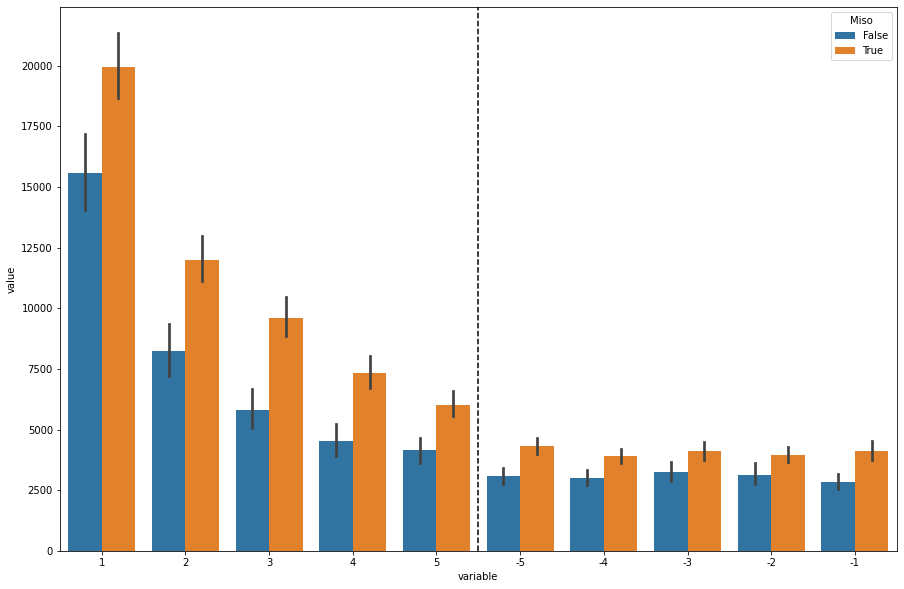

In [288]:
df = pd.read_parquet("/gstock/EXOTIC/data/GENOMICS/RefSeq_exons_simple.parquet")

df["Introns_lengths"] = df["Introns_ranges"].apply(lambda r: [int(e.split("-")[1]) - int(e.split("-")[0]) for e in r])
df['Introns_nb'] = df['Introns_lengths'].str.len()
k = 10
df = df.loc[df['Introns_nb'] >= k]
df["Introns_lengths"] = df["Introns_lengths"].apply(lambda r: r[:int(k/2)] + r[-int(k/2):])


l = list()
for condition in [True, False]:
    tmp_df = df.loc[df['Miso'] == condition]
    X = pd.DataFrame.from_records(tmp_df.Introns_lengths.values)
    print(X.shape)
    X = X.melt()
    X = X.loc[X['value'] > 0]
    X['Miso'] = condition
    l.append(X)
X = pd.concat(l)

f, ax = plt.subplots(figsize=(15,10))
sns.barplot(data=X, x='variable', y='value', hue='Miso')
plt.axvline(int(k/2) - 0.5, color='black', linestyle='--')
first_labels = list(range(1,int(k/2)+1))
last_labels = [-1*e for e in list(reversed(list(range(1,int(k/2)+1))))]
ax.set_xticklabels(first_labels + last_labels)
# plt.ylim(0,1e5)

In [341]:
refseq_gene_level_path = "/gstock/EXOTIC/data/GENOMICS/TMP/refseq_cds_exons_concat_filtered.parquet"
genes_remap_raw = pd.read_parquet(refseq_gene_level_path).sort_values(by=["Gene", "ranges"])
genes_remap_raw = genes_remap_raw.loc[genes_remap_raw["Exon_type"] == "CDS"].drop_duplicates(subset=["Gene", "ranges"])
genes_remap = genes_remap_raw[["Gene", "Gene_start", "Gene_stop"]].drop_duplicates().sort_values(by="Gene")
genes_remap['Length'] = genes_remap['Gene_stop'] - genes_remap['Gene_start']
# genes_remap = pd.merge(genes_remap, df[['Gene', 'Miso']], on='Gene')
# genes_remap['Miso'] = genes_remap['Miso'].astype(str)

In [350]:
genes_remap_data.Miso.value_counts().to_dict()


{'True': 7690, 'False': 3914}

Text(0, 0.5, '')

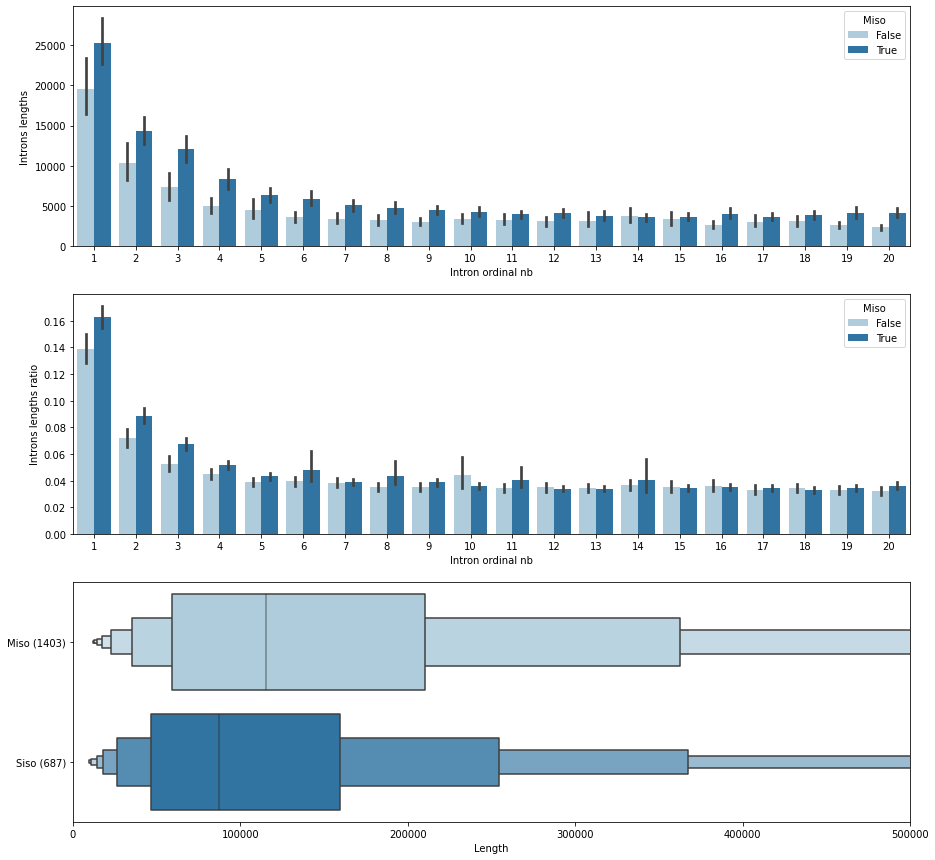

In [356]:
df = pd.read_parquet("/gstock/EXOTIC/data/GENOMICS/RefSeq_exons_simple.parquet")

df["Introns_lengths"] = df["Introns_ranges"].apply(lambda r: [int(e.split("-")[1]) - int(e.split("-")[0]) for e in r])
df['Introns_nb'] = df['Introns_lengths'].str.len()

k = 20
df = df.loc[df['Introns_nb'] >= k]

df["Introns_lengths_pct"] = df["Introns_lengths"].apply(lambda r: pd.Series(r).rank(pct=True).round(2).values.tolist())
df["Introns_lengths_ratio"] = df["Introns_lengths"].apply(lambda r: pd.Series(pd.Series(r) / pd.Series(r).sum()).round(2).values.tolist())

df["Introns_lengths_pct"] = df["Introns_lengths_pct"].apply(lambda r: r[:k])
df["Introns_lengths_ratio"] = df["Introns_lengths_ratio"].apply(lambda r: r[:k])
df["Introns_lengths"] = df["Introns_lengths"].apply(lambda r: r[:k])


f, ax = plt.subplots(nrows=3, figsize=(15,15))

for i, col in enumerate(['Introns_lengths', 'Introns_lengths_ratio']):
    

    l = list()
    for condition in [True, False]:
        tmp_df = df.loc[df['Miso'] == condition]
        X = pd.DataFrame.from_records(tmp_df[col].values)
        X = X.melt()
        X = X.loc[X['value'] > 0]
        X['Miso'] = condition
        l.append(X)
    X = pd.concat(l)

    sns.barplot(data=X, x='variable', y='value', hue='Miso', ax=ax[i], palette='Paired')
    # plt.axvline(int(k/2) - 0.5, color='black', linestyle='--')
    first_labels = list(range(1,k+1))
    # last_labels = [-1*e for e in list(reversed(list(range(1,int(k/2)+1))))]
    ax[i].set_xticklabels(first_labels)
    ax[i].set_xlabel('Intron ordinal nb')
    ax[i].set_ylabel(col.replace('_', ' '))

# refseq_gene_level_path = "/gstock/EXOTIC/data/GENOMICS/TMP/refseq_cds_exons_concat_filtered.parquet"
# genes_remap_raw = pd.read_parquet(refseq_gene_level_path).sort_values(by=["Gene", "ranges"])
# genes_remap_raw = genes_remap_raw.loc[genes_remap_raw["Exon_type"] == "CDS"].drop_duplicates(subset=["Gene", "ranges"])
# genes_remap = genes_remap_raw[["Gene", "Gene_start", "Gene_stop"]].drop_duplicates().sort_values(by="Gene")
# genes_remap['Length'] = genes_remap['Gene_stop'] - genes_remap['Gene_start']

genes_remap_data = pd.merge(genes_remap, df[['Gene', 'Miso']], on='Gene')
genes_remap_data['Miso'] = genes_remap_data['Miso'].astype(str)
d = genes_remap_data.Miso.value_counts().to_dict()
genes_remap_data['Miso'] = genes_remap_data['Miso'].replace({'True': 'Miso ({})'.format(d['True']), 'False' : 'Siso ({})'.format(d['False'])})
genes_remap_data = genes_remap_data.sort_values(by=['Miso'], ascending=True)


sns.boxenplot(data=genes_remap_data, x='Length', y='Miso', palette='Paired', showfliers=False, ax=ax[i+1])
ax[i+1].set_xlim(0,0.5e6)
ax[i+1].set_ylabel('')



/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

[[0.09, 0.34, 0.08, 0.05, 0.05, 0.04, 0.04, 0.04, 0.04, 0.03], [0.09, 0.06, 0.08, 0.07, 0.06, 0.06, 0.06, 0.05, 0.05, 0.05], [0.42, 0.08, 0.06, 0.05, 0.04, 0.04, 0.03, 0.03, 0.03, 0.03]]
3 Introns_lengths 3
         False  True     Ratio      Fold
cluster                                 
0         4203  7793  1.854152  0.972046
1           23    51  2.217391  1.162475
2          216   629  2.912037  1.526646
Sum       4442  8473  1.907474  1.000000


Line2D(_nolegend_)
Line2D(_nolegend_)
Line2D(_nolegend_)


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:139: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:139: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:139: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significa

[[0.09, 0.34, 0.08, 0.05, 0.05, 0.04, 0.04, 0.04, 0.04, 0.03], [0.09, 0.06, 0.08, 0.07, 0.06, 0.06, 0.06, 0.05, 0.05, 0.05], [0.42, 0.08, 0.06, 0.05, 0.04, 0.04, 0.03, 0.03, 0.03, 0.03]]
5 Introns_lengths 3
          False    True     Ratio      Fold
cluster                                    
0        3317.0  6614.0  1.993970  0.988029
1           NaN     2.0       NaN       NaN
2         103.0   286.0  2.776699  1.375878
Sum      3420.0  6902.0  2.018129  1.000000


Line2D(_nolegend_)
Line2D(_nolegend_)
Line2D(_nolegend_)


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:139: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:139: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

[[0.09, 0.34, 0.08, 0.05, 0.05, 0.04, 0.04, 0.04, 0.04, 0.03], [0.09, 0.06, 0.08, 0.07, 0.06, 0.06, 0.06, 0.05, 0.05, 0.05], [0.42, 0.08, 0.06, 0.05, 0.04, 0.04, 0.03, 0.03, 0.03, 0.03]]
10 Introns_lengths 3
         False  True     Ratio      Fold
cluster                                 
0          110   385  3.500000  1.587702
1         1679  3540  2.108398  0.956430
2           11    43  3.909091  1.773277
Sum       1800  3968  2.204444  1.000000


Line2D(_nolegend_)
Line2D(_nolegend_)
Line2D(_nolegend_)


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:139: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:139: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:139: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significa

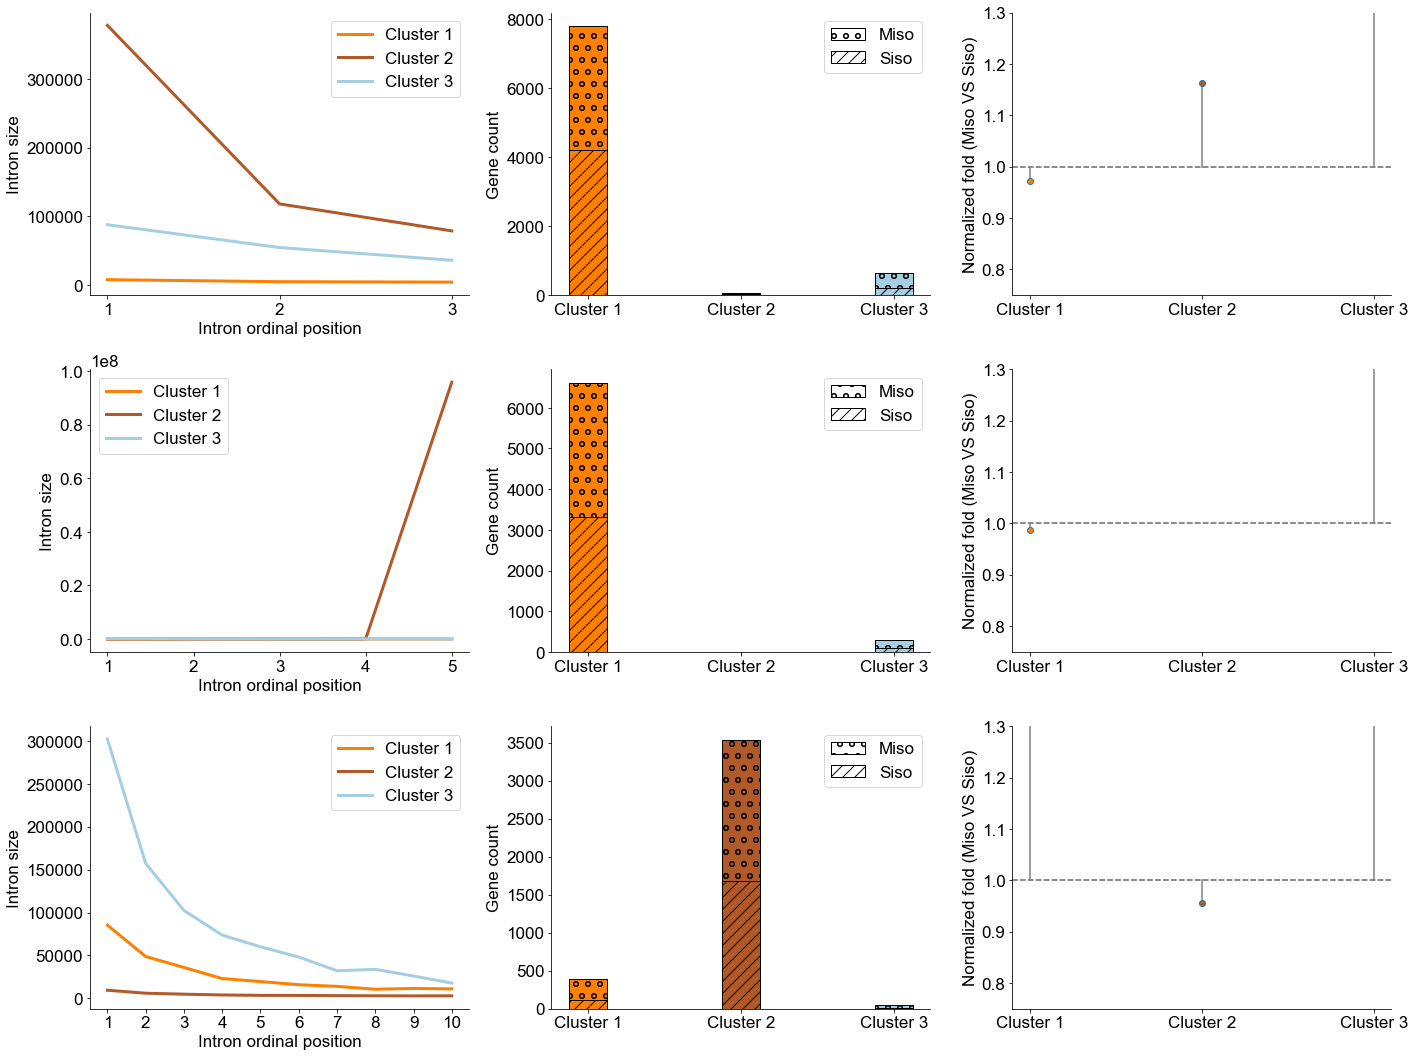

In [462]:
# import matplotlib.font_manager as font_manager

# font_dirs = ['/home/weber/Fonts', ]
# font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
# font_list = font_manager.createFontList(font_files)
# font_manager.fontManager.ttflist.extend(font_list)

# from matplotlib import rcParams
# rcParams['font.family'] = 'sans-serif'
# rcParams['font.sans-serif'] = ['Arial']
# rcParams['font.weight'] = 'light'
# plt.rcParams.update({'font.size' : 17})

from matplotlib.lines import Line2D   
import matplotlib.patches as mpatches



import random 

random.seed(1)
colors = sns.color_palette("Paired")
random.shuffle(colors)


# df = pd.read_parquet("/gstock/EXOTIC/data/GENOMICS/raw_matrix_clustering.parquet")
df_raw = pd.read_parquet("/gstock/EXOTIC/data/GENOMICS/RefSeq_exons_simple.parquet")

df_raw["Introns_lengths"] = df_raw["Introns_ranges"].apply(lambda r: [int(e.split("-")[1]) - int(e.split("-")[0]) for e in r])
df_raw['Introns_nb'] = df_raw['Introns_lengths'].str.len()

keys = [3,5,10]
clusters = [3]

f, ax = plt.subplots(nrows=3, ncols=3, figsize=(20,15))

for i, k in enumerate(keys):


    df = df_raw.loc[(df_raw["Introns_nb"] > k)]

#     df["Introns_lengths_pct"] = df["Introns_lengths"].apply(lambda r: pd.Series(r).rank(pct=True).round(2).values.tolist())
    df["Introns_lengths_ratio"] = df["Introns_lengths"].apply(lambda r: pd.Series(pd.Series(r) / pd.Series(r).sum()).round(2).values.tolist())
#     df["Introns_lengths_pct"] = df["Introns_lengths_pct"].apply(lambda r: r[:k])
    df["Introns_lengths_ratio"] = df["Introns_lengths_ratio"].apply(lambda r: r[:k])
    df["Introns_lengths"] = df["Introns_lengths"].apply(lambda r: r[:k])
    
    df = df.reset_index(drop=True)

#     for i, x in enumerate(['Introns_lengths_ratio']):
    for x in ['Introns_lengths']:

        X_raw = pd.DataFrame.from_records(df[x])
        
        for cluster in clusters:

            X = X_raw.copy()
            
            km = KMeans(n_clusters=cluster)
            km.fit(X.values)
            cluster_centers = km.cluster_centers_
            cluster_centers = [[round(sub_e, 2) for sub_e in e] for e in cluster_centers]
            
            print(cluster_centers_raw)

            cluster_map = pd.DataFrame()
            cluster_map["data_index"] = X.index.values
            cluster_map["cluster"] = km.labels_
            
            
            X['cluster'] = cluster_map.cluster
            
            X['Miso'] = df['Miso']
            X['Gene'] = df['Gene']
            X['Introns_ranges'] = df['Introns_ranges']
            X['Introns_lengths'] = df['Introns_lengths']
            
            
            # X.groupby(['cluster'])['Miso'].value_counts().to_dict()
            gb = X.groupby(['cluster'])['Miso'].value_counts().rename('Count').reset_index().pivot(index='cluster', columns='Miso', values='Count')
            gb.loc['Sum'] = gb.sum()
            gb['Ratio'] = gb[True] / gb[False]
            gb['Fold'] = gb['Ratio'] / gb.loc['Sum']['Ratio']
            gb.columns = [str(c) for c in gb.columns]
            
            
            
            print(k, x, cluster)
            print(gb)
            print('\n')
            
#             gb_barplot = gb.drop('Sum').reset_index().melt(id_vars='cluster', value_vars=['True','False'])
            legend_lineplot_handles = list()
            legend_lineplot_labels = list()
            for (j, c), color in zip(enumerate(cluster_centers), colors):
                ax[i][0].plot([str(e) for e in range(1, len(c)+1)], c, color=color, lw=3)
                ax[i][0].set_ylabel('Intron size')
                ax[i][0].set_xlabel('Intron ordinal position')
                ax[i][0].spines['top'].set_linewidth(0)
                ax[i][0].spines['right'].set_linewidth(0)
#                 ax[i][0].set_xticklabels([str(e) for e in range(1,k+1)])

#                 handles, labels = ax[i][0].get_legend_handles_labels()
                legend_lineplot_handles.append(Line2D([0], [0], color=color, lw=3))
                legend_lineplot_labels.append( "Cluster {}".format(str(j+1)))
                
                if j == cluster-1:
                    ax[i][0].legend(legend_lineplot_handles, legend_lineplot_labels)
#                 ax[i][0].minorticks_off()



                ax[i][1].bar(j, gb.loc[j]['True'], color = color, width = 0.25, hatch="o", edgecolor='black')
                ax[i][1].bar('Cluster {}'.format(str(j+1)), gb.loc[j]['False'], color = color, width = 0.25, hatch="//", edgecolor='black')
                ax[i][1].set_ylabel('Gene count')

                ax[i][1].spines['top'].set_linewidth(0)
                ax[i][1].spines['right'].set_linewidth(0)
                
                ax[i][1].legend(
                    [
                        mpatches.Patch(facecolor="white", hatch="o",  edgecolor='black'),
                        mpatches.Patch(facecolor="white", hatch="//",  edgecolor='black')
                    ],
                    [
                       "Miso", "Siso", 
                    ]
                )
#                 ax[i][1].set_xticklabels(['Cluster 1', '2', '3'])

#                 ax[i][2].stem(j+1, gb.loc[j]['Fold'], bottom=1)
# #                 markerline.set_markerfacecolor(color)
#                 ax[i][2].axhline(1, color='black', alpha=0.5, ls='--')
#                 ax[i][2].set_ylabel('Normalized fold (Miso VS Siso)')
#                 ax[i][2].spines['top'].set_linewidth(0)
#                 ax[i][2].spines['right'].set_linewidth(0)
#                 ax[i][2].set_ylim(0.8,1.3)

                markerline, stemlines, baseline = ax[i][2].stem(["Cluster {}".format(j+1)], [gb.loc[j]['Fold']], bottom=1, linefmt = 'grey')
                markerline.set_markerfacecolor(color)
                print(markerline)
                ax[i][2].axhline(1, color='grey', alpha=0.7, ls='--')


                ax[i][2].set_ylabel('Normalized fold (Miso VS Siso)')
                ax[i][2].spines['top'].set_linewidth(0)
                ax[i][2].spines['right'].set_linewidth(0)
                ax[i][2].set_ylim(0.5,2)
    
#             sns.barplot(data=gb_barplot, x='cluster', y='value', hue='variable', ax=ax[i][1], palette=['r', 'b', 'g'])
#             gb_barplot.loc[gb_barplot['variable'] == 'True']

                
            
plt.tight_layout()

/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

[[0.09, 0.34, 0.08, 0.05, 0.05, 0.04, 0.04, 0.04, 0.04, 0.03], [0.09, 0.06, 0.08, 0.07, 0.06, 0.06, 0.06, 0.05, 0.05, 0.05], [0.42, 0.08, 0.06, 0.05, 0.04, 0.04, 0.03, 0.03, 0.03, 0.03]]
3 Introns_lengths_ratio 3
         False  True     Ratio      Fold
cluster                                 
0          649  1424  2.194145  1.150288
1         1271  2151  1.692368  0.887230
2         2522  4898  1.942109  1.018158
Sum       4442  8473  1.907474  1.000000


Line2D(_nolegend_)
Line2D(_nolegend_)
Line2D(_nolegend_)


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:139: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:139: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:139: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significa

[[0.09, 0.34, 0.08, 0.05, 0.05, 0.04, 0.04, 0.04, 0.04, 0.03], [0.09, 0.06, 0.08, 0.07, 0.06, 0.06, 0.06, 0.05, 0.05, 0.05], [0.42, 0.08, 0.06, 0.05, 0.04, 0.04, 0.03, 0.03, 0.03, 0.03]]
5 Introns_lengths_ratio 3
         False  True     Ratio      Fold
cluster                                 
0         2080  4147  1.993750  0.987920
1          915  1674  1.829508  0.906537
2          425  1081  2.543529  1.260341
Sum       3420  6902  2.018129  1.000000


Line2D(_nolegend_)
Line2D(_nolegend_)
Line2D(_nolegend_)


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:139: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:139: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:139: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significa

[[0.09, 0.34, 0.08, 0.05, 0.05, 0.04, 0.04, 0.04, 0.04, 0.03], [0.09, 0.06, 0.08, 0.07, 0.06, 0.06, 0.06, 0.05, 0.05, 0.05], [0.42, 0.08, 0.06, 0.05, 0.04, 0.04, 0.03, 0.03, 0.03, 0.03]]
10 Introns_lengths_ratio 3
         False  True     Ratio      Fold
cluster                                 
0         1187  2476  2.085931  0.946239
1          422   956  2.265403  1.027652
2          191   536  2.806283  1.273011
Sum       1800  3968  2.204444  1.000000


Line2D(_nolegend_)
Line2D(_nolegend_)
Line2D(_nolegend_)


/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:139: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:139: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
/home/weber/.conda/envs/ExoCarto/lib/python3.7/site-packages/ipykernel_launcher.py:139: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significa

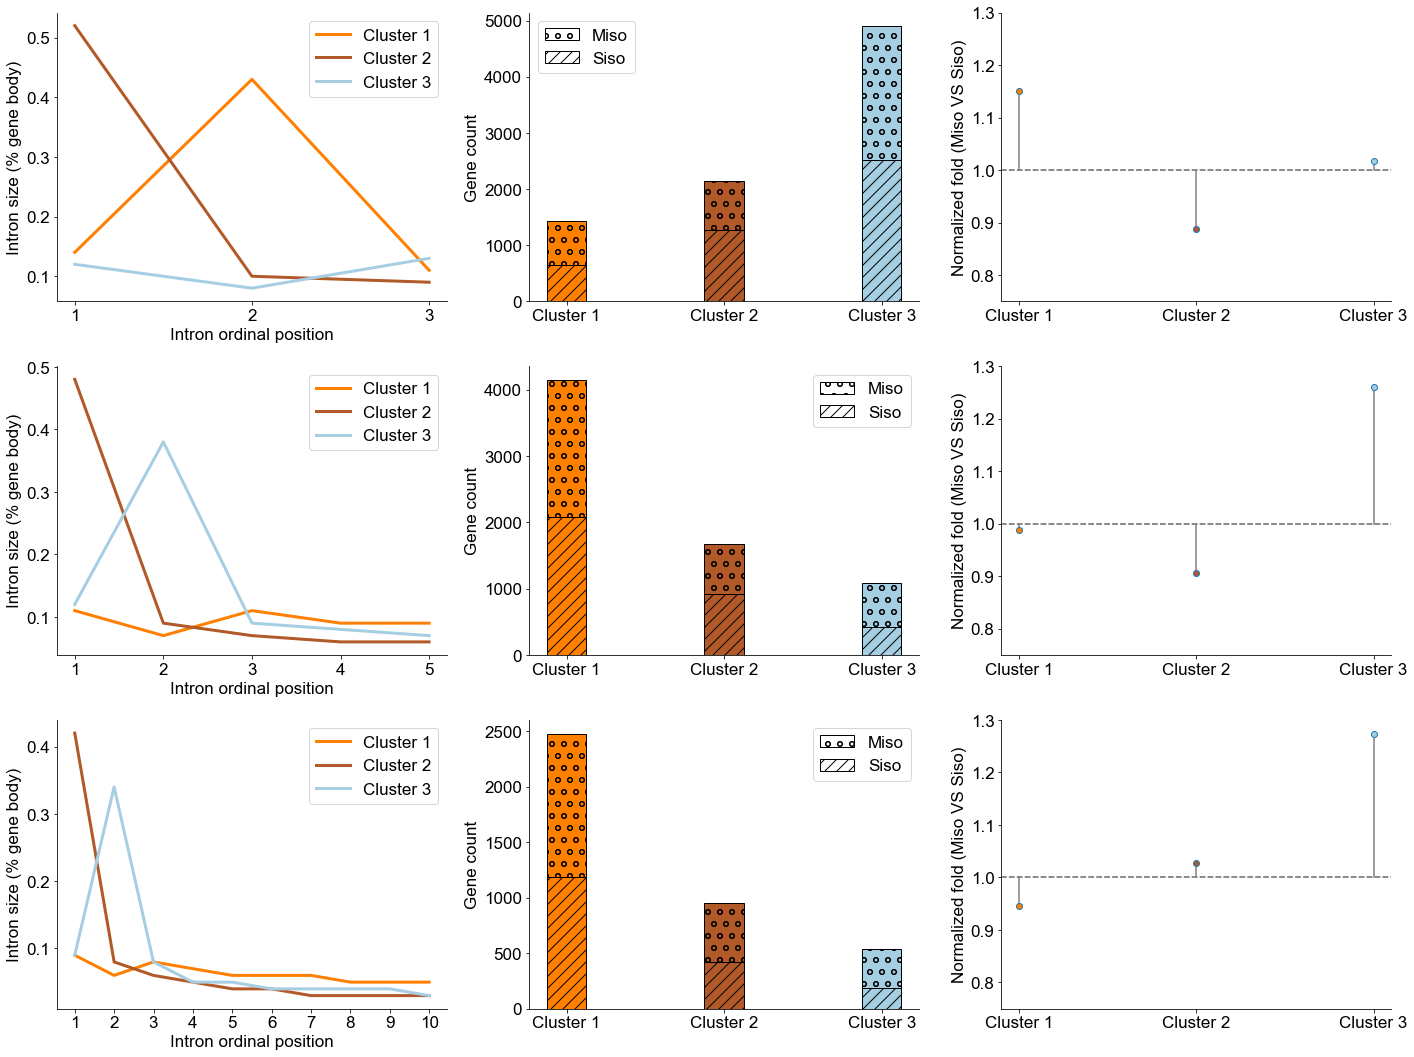

In [460]:
# import matplotlib.font_manager as font_manager

# font_dirs = ['/home/weber/Fonts', ]
# font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
# font_list = font_manager.createFontList(font_files)
# font_manager.fontManager.ttflist.extend(font_list)

# from matplotlib import rcParams
# rcParams['font.family'] = 'sans-serif'
# rcParams['font.sans-serif'] = ['Arial']
# rcParams['font.weight'] = 'light'
# plt.rcParams.update({'font.size' : 17})

from matplotlib.lines import Line2D   
import matplotlib.patches as mpatches



import random 

random.seed(1)
colors = sns.color_palette("Paired")
random.shuffle(colors)


# df = pd.read_parquet("/gstock/EXOTIC/data/GENOMICS/raw_matrix_clustering.parquet")
df_raw = pd.read_parquet("/gstock/EXOTIC/data/GENOMICS/RefSeq_exons_simple.parquet")

df_raw["Introns_lengths"] = df_raw["Introns_ranges"].apply(lambda r: [int(e.split("-")[1]) - int(e.split("-")[0]) for e in r])
df_raw['Introns_nb'] = df_raw['Introns_lengths'].str.len()

keys = [3,5,10]
clusters = [3]

f, ax = plt.subplots(nrows=3, ncols=3, figsize=(20,15))

for i, k in enumerate(keys):


    df = df_raw.loc[(df_raw["Introns_nb"] > k)]

#     df["Introns_lengths_pct"] = df["Introns_lengths"].apply(lambda r: pd.Series(r).rank(pct=True).round(2).values.tolist())
    df["Introns_lengths_ratio"] = df["Introns_lengths"].apply(lambda r: pd.Series(pd.Series(r) / pd.Series(r).sum()).round(2).values.tolist())
#     df["Introns_lengths_pct"] = df["Introns_lengths_pct"].apply(lambda r: r[:k])
    df["Introns_lengths_ratio"] = df["Introns_lengths_ratio"].apply(lambda r: r[:k])
    df["Introns_lengths"] = df["Introns_lengths"].apply(lambda r: r[:k])
    
    df = df.reset_index(drop=True)

#     for i, x in enumerate(['Introns_lengths_ratio']):
    for x in ['Introns_lengths_ratio']:

        X_raw = pd.DataFrame.from_records(df[x])
        
        for cluster in clusters:

            X = X_raw.copy()
            
            km = KMeans(n_clusters=cluster)
            km.fit(X.values)
            cluster_centers = km.cluster_centers_
            cluster_centers = [[round(sub_e, 2) for sub_e in e] for e in cluster_centers]
            
            print(cluster_centers_raw)

            cluster_map = pd.DataFrame()
            cluster_map["data_index"] = X.index.values
            cluster_map["cluster"] = km.labels_
            
            
            X['cluster'] = cluster_map.cluster
            
            X['Miso'] = df['Miso']
            X['Gene'] = df['Gene']
            X['Introns_ranges'] = df['Introns_ranges']
            X['Introns_lengths'] = df['Introns_lengths']
            
            
            # X.groupby(['cluster'])['Miso'].value_counts().to_dict()
            gb = X.groupby(['cluster'])['Miso'].value_counts().rename('Count').reset_index().pivot(index='cluster', columns='Miso', values='Count')
            gb.loc['Sum'] = gb.sum()
            gb['Ratio'] = gb[True] / gb[False]
            gb['Fold'] = gb['Ratio'] / gb.loc['Sum']['Ratio']
            gb.columns = [str(c) for c in gb.columns]
            
            
            
            print(k, x, cluster)
            print(gb)
            print('\n')
            
#             gb_barplot = gb.drop('Sum').reset_index().melt(id_vars='cluster', value_vars=['True','False'])
            legend_lineplot_handles = list()
            legend_lineplot_labels = list()
            for (j, c), color in zip(enumerate(cluster_centers), colors):
                ax[i][0].plot([str(e) for e in range(1, len(c)+1)], c, color=color, lw=3)
                ax[i][0].set_ylabel('Intron size (% gene body)')
                ax[i][0].set_xlabel('Intron ordinal position')
                ax[i][0].spines['top'].set_linewidth(0)
                ax[i][0].spines['right'].set_linewidth(0)
#                 ax[i][0].set_xticklabels([str(e) for e in range(1,k+1)])

#                 handles, labels = ax[i][0].get_legend_handles_labels()
                legend_lineplot_handles.append(Line2D([0], [0], color=color, lw=3))
                legend_lineplot_labels.append( "Cluster {}".format(str(j+1)))
                
                if j == cluster-1:
                    ax[i][0].legend(legend_lineplot_handles, legend_lineplot_labels)
#                 ax[i][0].minorticks_off()



                ax[i][1].bar(j, gb.loc[j]['True'], color = color, width = 0.25, hatch="o", edgecolor='black')
                ax[i][1].bar('Cluster {}'.format(str(j+1)), gb.loc[j]['False'], color = color, width = 0.25, hatch="//", edgecolor='black')
                ax[i][1].set_ylabel('Gene count')

                ax[i][1].spines['top'].set_linewidth(0)
                ax[i][1].spines['right'].set_linewidth(0)
                
                ax[i][1].legend(
                    [
                        mpatches.Patch(facecolor="white", hatch="o",  edgecolor='black'),
                        mpatches.Patch(facecolor="white", hatch="//",  edgecolor='black')
                    ],
                    [
                       "Miso", "Siso", 
                    ]
                )
#                 ax[i][1].set_xticklabels(['Cluster 1', '2', '3'])

#                 ax[i][2].stem(j+1, gb.loc[j]['Fold'], bottom=1)
# #                 markerline.set_markerfacecolor(color)
#                 ax[i][2].axhline(1, color='black', alpha=0.5, ls='--')
#                 ax[i][2].set_ylabel('Normalized fold (Miso VS Siso)')
#                 ax[i][2].spines['top'].set_linewidth(0)
#                 ax[i][2].spines['right'].set_linewidth(0)
#                 ax[i][2].set_ylim(0.8,1.3)

                markerline, stemlines, baseline = ax[i][2].stem(["Cluster {}".format(j+1)], [gb.loc[j]['Fold']], bottom=1, linefmt = 'grey')
                markerline.set_markerfacecolor(color)
                print(markerline)
                ax[i][2].axhline(1, color='grey', alpha=0.7, ls='--')


                ax[i][2].set_ylabel('Normalized fold (Miso VS Siso)')
                ax[i][2].spines['top'].set_linewidth(0)
                ax[i][2].spines['right'].set_linewidth(0)
                ax[i][2].set_ylim(0.75,1.3)
    
#             sns.barplot(data=gb_barplot, x='cluster', y='value', hue='variable', ax=ax[i][1], palette=['r', 'b', 'g'])
#             gb_barplot.loc[gb_barplot['variable'] == 'True']

                
            
plt.tight_layout()

In [208]:
# X = pd.DataFrame.from_records(df["Introns_lengths"])
X = pd.DataFrame.from_records(df["Introns_lengths_ratio"])
# X = pd.DataFrame.from_records(df["Introns_lengths_pct"])
# X.to_csv('/gstock/EXOTIC/data/GENOMICS/TMP/cluspack_test.tsv', sep='\t')
X

,0,1,2,3,4
0,0.05,0.07,0.01,0.01,0.04
1,0.01,0.01,0.12,0.10,0.02
2,0.05,0.39,0.02,0.02,0.02
3,0.12,0.04,0.14,0.07,0.16
4,0.04,0.04,0.31,0.19,0.09
...,...,...,...,...,...
9887,0.08,0.00,0.03,0.13,0.11
9888,0.32,0.16,0.09,0.05,0.05
9889,0.06,0.02,0.02,0.66,0.02
9890,0.15,0.05,0.02,0.01,0.02


[[0.84, 0.31, 0.67, 0.6, 0.58],
 [0.9, 0.78, 0.42, 0.46, 0.43],
 [0.33, 0.8, 0.7, 0.58, 0.59]]

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)
[[0.12, 0.1, 0.1, 0.09, 0.38],
 [0.25, 0.07, 0.07, 0.07, 0.06],
 [0.7, 0.07, 0.05, 0.04, 0.04],
 [0.13, 0.1, 0.1, 0.4, 0.09],
 [0.34, 0.29, 0.09, 0.07, 0.07],
 [0.11, 0.1, 0.42, 0.08, 0.08],
 [0.46, 0.07, 0.09, 0.08, 0.07],
 [0.09, 0.26, 0.1, 0.09, 0.08],
 [0.06, 0.05, 0.06, 0.06, 0.05],
 [0.09, 0.55, 0.08, 0.06, 0.06]]


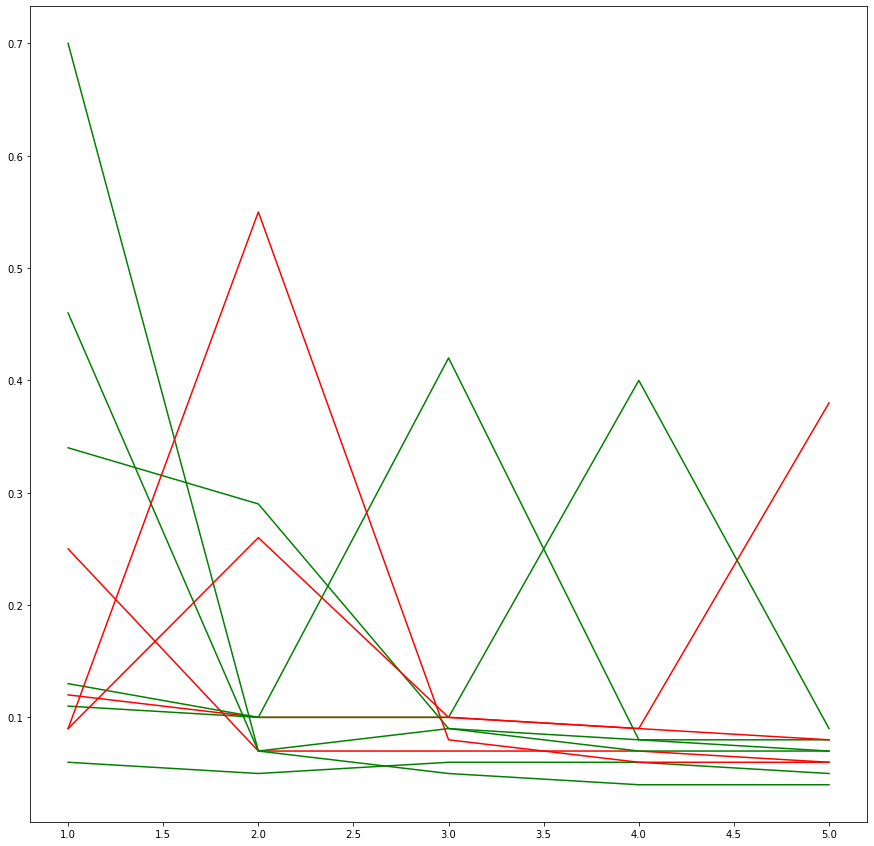

In [217]:
X = pd.DataFrame.from_records(df["Introns_lengths_ratio"])


from sklearn.cluster import MiniBatchKMeans, KMeans
from pprint import pprint

km = KMeans(n_clusters=10)
print(km)
km.fit(X.values)
cluster_centers = km.cluster_centers_
cluster_centers = [[round(sub_e, 2) for sub_e in e] for e in cluster_centers]

pprint(cluster_centers)

cluster_map = pd.DataFrame()
cluster_map["data_index"] = X.index.values
cluster_map["cluster"] = km.labels_
X['cluster'] = cluster_map.cluster
X['Miso'] = df['Miso']
d = X.groupby(['cluster'])['Miso'].unique().to_dict()
d = {k:v[0] for k,v in d.items()}
d_color = {True: 'green', False : 'red'}

plt.figure(figsize=(15,15))
for j, c in enumerate(cluster_centers):
    plt.plot(range(1, len(c)+1), c, color=d_color[d[j]])
    plt.minorticks_off()


In [237]:
X = pd.DataFrame.from_records(df["Introns_lengths_ratio"])

km = KMeans(n_clusters=3)
print(km)
km.fit(X.values)
cluster_centers = km.cluster_centers_
cluster_centers = [[round(sub_e, 2) for sub_e in e] for e in cluster_centers]

cluster_map = pd.DataFrame()
cluster_map["data_index"] = X.index.values
cluster_map["cluster"] = km.labels_
X['cluster'] = cluster_map.cluster
X['Miso'] = df['Miso']
# X.groupby(['cluster'])['Miso'].value_counts().to_dict()
gb = X.groupby(['cluster'])['Miso'].value_counts().rename('Count').reset_index().pivot(index='cluster', columns='Miso', values='Count')
gb.loc['Sum'] = gb.sum()
gb['Ratio'] = gb[True] / gb[False]
gb['Fold'] = gb['Ratio'] / gb.loc['Sum']['Ratio']
cm = sns.light_palette("green", as_cmap=True)
# gb.Fold.style.background_gradient(cmap=cm)
gb


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)


Miso,False,True,Ratio,Fold
cluster,,,,
0,2357,3378,1.433178,1.012397
1,1157,1479,1.278306,0.902995
2,581,940,1.617900,1.142884
Sum,4095,5797,1.415629,1.000000


In [201]:
d = X.groupby(['cluster'])['Miso'].unique().to_dict()
d = {k:v[0] for k,v in d.items()}
d

{0: True,
 1: False,
 2: True,
 3: False,
 4: True,
 5: False,
 6: False,
 7: True,
 8: True,
 9: False}

ValueError: The palette list has the wrong number of colors.

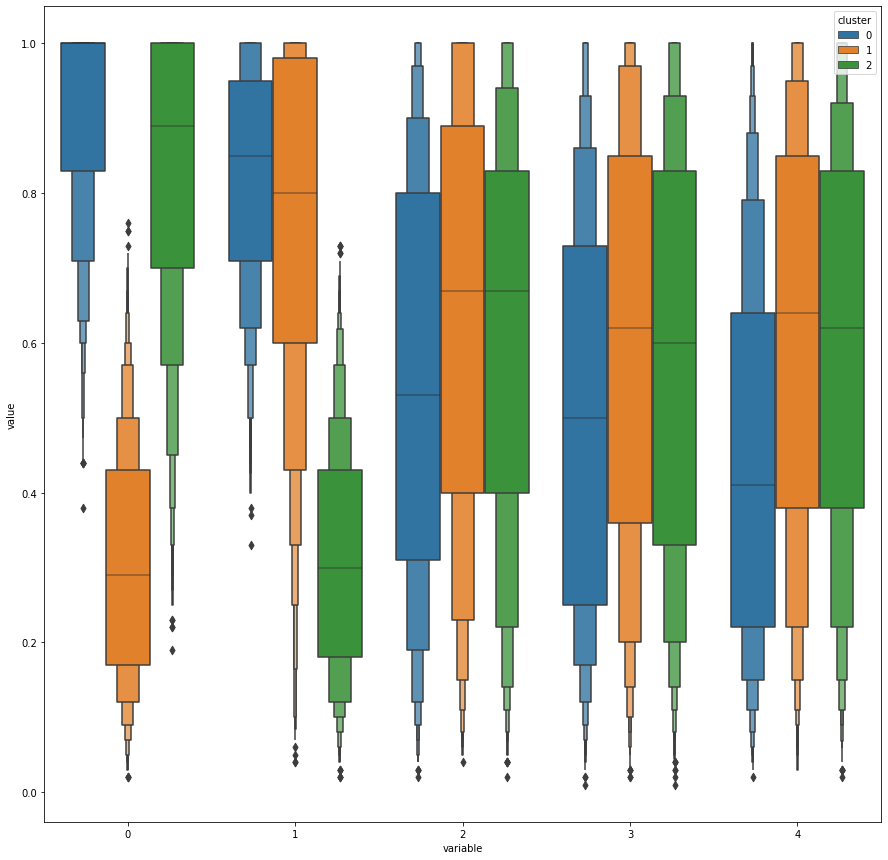

In [112]:
X_plot = X.melt(id_vars=['cluster', 'Miso'], value_vars=[col for col in X if col not in ['cluster', 'Miso']])
plt.figure(figsize=(15,15))
sns.boxenplot(data=X_plot, x='variable', y='value', hue='cluster', palette=sns.color_palette())
sns.lineplot(data=X_plot, x='variable', y='value', hue='cluster', palette=sns.color_palette())
# plt.ylim(0,0.2e5)

In [47]:
from sklearn.decomposition import PCA, IncrementalPCA
n_components = 2
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)
df[['PCA1', 'PCA2']] = X_pca
df.Miso.value_counts()

True     3372
False    2216
Name: Miso, dtype: int64

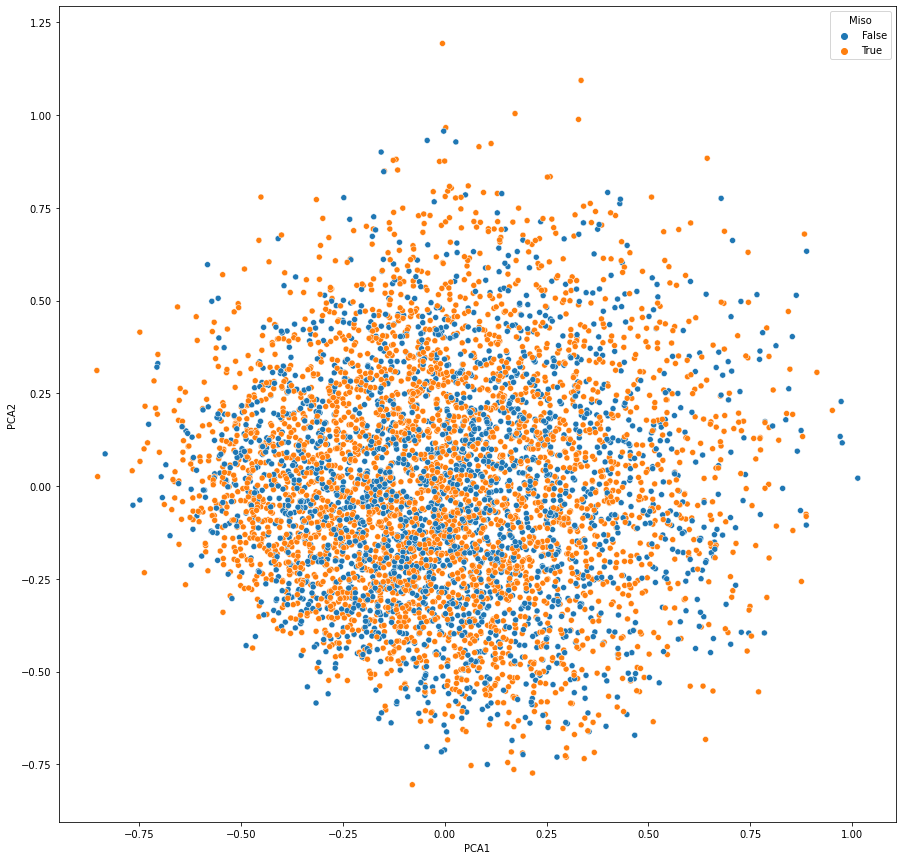

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(15,15))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Miso')